In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"herutriana","key":"b1c523025df16e543e5b14c63b5851ae"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
!ls

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 101MB/s]
kaggle.json  sample_data  stock-time-series-20050101-to-20171231.zip


In [ ]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf

In [24]:
import zipfile
zip_ref = zipfile.ZipFile('stock-time-series-20050101-to-20171231.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
 
df = pd.read_csv('/content/files/AABA_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA
...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA


In [25]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [27]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')
 
df = pd.read_csv('/content/files/AABA_2006-01-01_to_2018-01-01.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume','Name']
df.index.name = 'Date'

In [28]:
df.drop('Name', inplace=True, axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 141.5 KB


In [30]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [31]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729
2006-01-04,41.22,41.90,40.77,40.97,20553479
2006-01-05,40.93,41.73,40.85,41.53,12829610
2006-01-06,42.88,43.57,42.80,43.21,29422828
2006-01-09,43.10,43.66,42.82,43.42,16268338
...,...,...,...,...,...
2017-12-22,71.42,71.87,71.22,71.58,10979165
2017-12-26,70.94,71.39,69.63,69.86,8542802
2017-12-27,69.77,70.49,69.69,70.06,6345124


In [32]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,28.426479,28.766532,28.066558,28.412726,2.158391e+07
std,13.257242,13.356692,13.157326,13.258163,1.926231e+07
min,9.100000,9.480000,8.940000,8.950000,1.939061e+06
25%,16.175000,16.385000,15.970000,16.130000,1.248025e+07
50%,27.180000,27.490000,26.820000,27.100000,1.732130e+07
75%,36.655000,37.035000,36.305000,36.635000,2.512757e+07
max,73.020000,73.250000,72.460000,72.930000,4.382317e+08


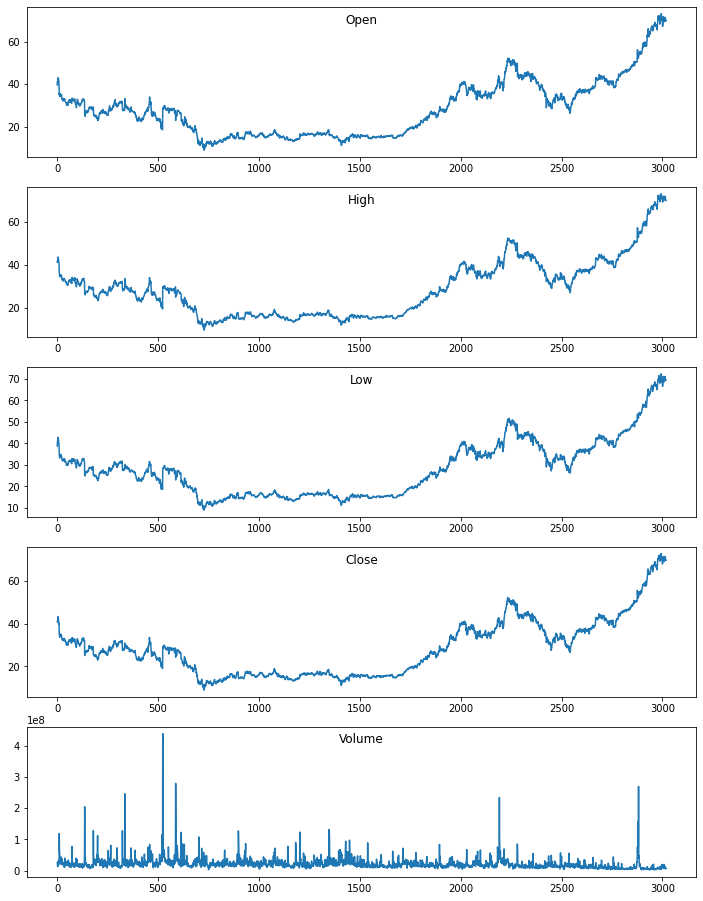

In [33]:
values = df.values
 
num_f = len(df.columns)
 
groups = [x for x in range(num_f)]
 
plt.figure(figsize = (12,16))
 
i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
plt.show()

In [34]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
# split train set
training_set = df['Open'].values
len_train = int(len(training_set)*0.8)
data_train = training_set[:len_train]
data_val = training_set[len_train:]

In [35]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [36]:
tf.keras.backend.clear_session()
 
train_set = windowed_dataset(data_train, window_size=60, batch_size=100, shuffle_buffer=1000)
 
model = Sequential([
  Bidirectional(LSTM(60, return_sequences=True)),
  Bidirectional(LSTM(60)),
  Dense(30, activation="relu"),
  Dropout(0.7),
  Dense(10, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
24/24 [==============================] - 44s 206ms/step - loss: 62.0972 - mae: 62.5972
Epoch 2/100
24/24 [==============================] - 5s 209ms/step - loss: 63.7385 - mae: 64.2385
Epoch 3/100
24/24 [==============================] - 5s 212ms/step - loss: 60.3903 - mae: 60.8903
Epoch 4/100
24/24 [==============================] - 5s 213ms/step - loss: 59.8730 - mae: 60.3730
Epoch 5/100
24/24 [==============================] - 5s 208ms/step - loss: 56.5179 - mae: 57.0179
Epoch 6/100
24/24 [==============================] - 5s 205ms/step - loss: 55.6245 - mae: 56.1245
Epoch 7/100
24/24 [==============================] - 5s 204ms/step - loss: 53.6471 - mae: 54.1471
Epoch 8/100
24/24 [==============================] - 5s 207ms/step - loss: 46.8225 - mae: 47.3225
Epoch 9/100
24/24 [==============================] - 5s 208ms/step - loss: 48.3595 - mae: 48.8595
Epoch 10/100
24/24 [==============================] - 5s 206ms/step - loss: 45.4431 - mae: 45.9431
Epoch 11/100
24/24

(1e-08, 0.001, 0.0, 300.0)

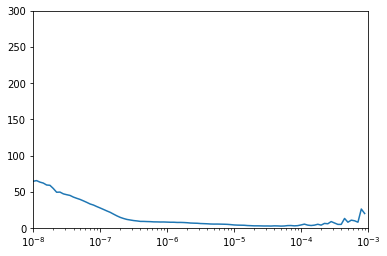

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [38]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\nMAE of the model <10% of data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [39]:
minMae = (df['Open'].max() - df['Open'].min()) * 10/100
minMae

6.3919999999999995

In [40]:
tf.keras.backend.clear_session()
 
train_set = windowed_dataset(data_train, window_size=60, batch_size=200, shuffle_buffer=1000)
 
model = Sequential([
  Bidirectional(LSTM(60, return_sequences=True)),
  Bidirectional(LSTM(60)),
  Dense(30, activation="relu"),
  Dropout(0.7),
  Dense(10, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 200)
])
 
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
12/12 [==============================] - 15s 413ms/step - loss: 37.6634 - mae: 38.1602
Epoch 2/500
12/12 [==============================] - 5s 407ms/step - loss: 12.9897 - mae: 13.4793
Epoch 3/500
12/12 [==============================] - 5s 405ms/step - loss: 9.1878 - mae: 9.6762

MAE of the model <10% of data scale


<Figure size 432x288 with 0 Axes>

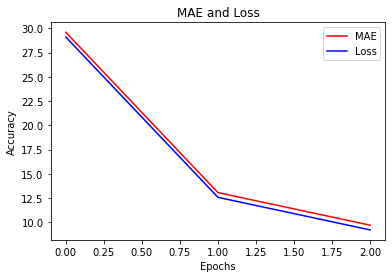

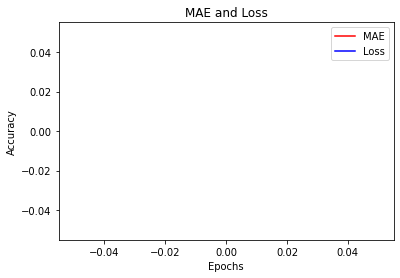

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
 
# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']
 
epochs=range(len(loss))
 
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
 
plt.figure()
 
# Plot Zoomed MAE and Loss
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]
 
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
 
plt.figure()